In [1]:
import sys
sys.path.append('..')
from src.func import iteratee

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data 

In [3]:
df = pd.read_csv("../data/raw/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.drop(columns="Insulin", inplace=True)

# Dataset Splitting 

In [5]:
X = df.drop(columns="Outcome")
y = df['Outcome'].values # .values digunakan karena Series/DataFrame pandas tidak bisa dikonversi ke Tensor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 7), (154, 7), (614,), (154,))

# Preprocess Data 

In [6]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
353,1,90,62,12,27.2,0.580,24
711,5,126,78,27,29.6,0.439,40
373,2,105,58,40,34.9,0.225,25
46,1,146,56,0,29.7,0.564,29
682,0,95,64,39,44.6,0.366,22


In [7]:
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, X_train.columns)
])

In [8]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

# Dataset

In [9]:
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [10]:
train_set = TensorDataset(X_train, y_train)
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set, batch_size=64)

# Training Preparation

In [11]:
X_train.shape

torch.Size([614, 7])

In [12]:
model = nn.Sequential(
    nn.Linear(7, 16),
    nn.ReLU(),
#     nn.Dropout(0.25),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4, 2),
    nn.LogSoftmax(1)
).to(device)

criterion = nn.NLLLoss()
#Semisal tidak menggunakan nn.LogSoftMax(), maka criterionnya menggunakan nn.CrossEntropyLoss
optimizer = optim.AdamW(model.parameters(), lr=0.003)

# Training Loop 

In [13]:
epochs = 1000

train_cost, test_cost = [], []
train_accuracy, test_accuracy = [], []

for i in range(epochs):
    cost, accuracy = iteratee("train", train_set, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost)
    train_accuracy.append(accuracy)
    
    with torch.no_grad():
        cost, accuracy = iteratee("test", test_set, testloader, model, criterion, optimizer, device)
        test_cost.append(cost)
        test_accuracy.append(accuracy)

    print(f"\rEpoch: {i+1:4}/{epochs:4} | "
          f"train_cost: {train_cost[-1]:.4f} | test_cost: {train_cost[-1]:.4f} | "
          f"train_accuracy: {train_accuracy[-1]:.4f} | test_accuracy: {test_accuracy[-1]:.4f}", end=" ")

Epoch: 1000/1000 | train_cost: 0.4150 | test_cost: 0.4150 | train_accuracy: 0.8029 | test_accuracy: 0.7532 

# Cost History 

In [14]:
import matplotlib.pyplot as plt

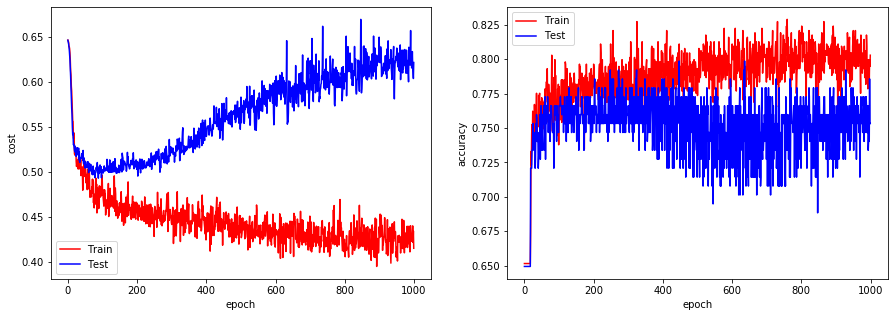

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(train_cost, 'r-', label="Train")
plt.plot(test_cost, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("cost"); plt.legend();
plt.subplot(122)
plt.plot(train_accuracy, 'r-', label="Train")
plt.plot(test_accuracy, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend();

# Predict

In [16]:
X_test.shape

torch.Size([154, 7])

In [17]:
with torch.no_grad():
    model.eval()
    output = model(X_test)

In [18]:
torch.exp(output)

tensor([[2.4622e-01, 7.5378e-01],
        [6.5650e-01, 3.4350e-01],
        [6.1907e-01, 3.8093e-01],
        [2.9096e-01, 7.0904e-01],
        [1.0000e+00, 3.0751e-08],
        [4.9309e-01, 5.0691e-01],
        [4.0999e-01, 5.9001e-01],
        [2.4622e-01, 7.5378e-01],
        [9.2394e-01, 7.6064e-02],
        [2.4622e-01, 7.5378e-01],
        [6.2684e-01, 3.7316e-01],
        [2.4622e-01, 7.5378e-01],
        [9.4212e-01, 5.7884e-02],
        [9.3234e-01, 6.7661e-02],
        [6.6804e-01, 3.3196e-01],
        [2.7223e-01, 7.2777e-01],
        [9.8697e-01, 1.3026e-02],
        [9.3675e-01, 6.3250e-02],
        [2.4622e-01, 7.5378e-01],
        [9.4055e-01, 5.9449e-02],
        [8.1662e-01, 1.8338e-01],
        [3.8501e-01, 6.1499e-01],
        [7.0598e-01, 2.9402e-01],
        [2.4622e-01, 7.5378e-01],
        [9.7488e-01, 2.5124e-02],
        [9.1063e-01, 8.9370e-02],
        [2.4622e-01, 7.5378e-01],
        [9.9151e-01, 8.4856e-03],
        [7.9135e-01, 2.0865e-01],
        [9.977

In [19]:
output

tensor([[-1.4015e+00, -2.8266e-01],
        [-4.2083e-01, -1.0686e+00],
        [-4.7953e-01, -9.6514e-01],
        [-1.2346e+00, -3.4385e-01],
        [ 0.0000e+00, -1.7297e+01],
        [-7.0706e-01, -6.7943e-01],
        [-8.9163e-01, -5.2761e-01],
        [-1.4015e+00, -2.8266e-01],
        [-7.9113e-02, -2.5762e+00],
        [-1.4015e+00, -2.8266e-01],
        [-4.6707e-01, -9.8574e-01],
        [-1.4015e+00, -2.8266e-01],
        [-5.9626e-02, -2.8493e+00],
        [-7.0058e-02, -2.6932e+00],
        [-4.0341e-01, -1.1027e+00],
        [-1.3011e+00, -3.1777e-01],
        [-1.3112e-02, -4.3408e+00],
        [-6.5339e-02, -2.7607e+00],
        [-1.4015e+00, -2.8266e-01],
        [-6.1289e-02, -2.8226e+00],
        [-2.0258e-01, -1.6962e+00],
        [-9.5448e-01, -4.8616e-01],
        [-3.4817e-01, -1.2241e+00],
        [-1.4015e+00, -2.8266e-01],
        [-2.5445e-02, -3.6840e+00],
        [-9.3619e-02, -2.4150e+00],
        [-1.4015e+00, -2.8266e-01],
        [-8.5219e-03, -4.769

In [20]:
pred = output.argmax(1)
pred

tensor([1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 0])

# Accuracy 

In [21]:
accuracy = (y_test == pred).to(torch.float32).mean().item()
accuracy

0.7532467246055603